In [1]:
import warnings
from pathlib import Path
import os
import pandas as pd
import tqdm
import random
import pickle

import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab
import socceraction.atomic.vaep.formula as vaepformula
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.data.wyscout import PublicWyscoutLoader

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as logistic
from sklearn.ensemble import RandomForestClassifier as rfc
from catboost import CatBoostClassifier 
from xgboost import XGBClassifier as XGBc
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

# Preprocessing

In [2]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [3]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [4]:
comp = ['Germany']
selected_competitions = competitions[(competitions['country_name'] =='Germany')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
4,426,181137,Germany,German first division,male,2017/2018


# Retrieve scoreline of a game

In [5]:
dfs_matches = []
#Retrieve matches of a selected competition
for competition in comp:
    competition_name = competition
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)
    
#Create a unique dataframe containing all the selected games
df_matches = pd.concat(dfs_matches)
df_matches.reset_index(drop = True, inplace = True)
df_matches.head(1)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405517,34,"{'2444': {'scoreET': 0, 'coachId': 14710, 'sid...",181137,2018-05-12 13:30:00,2445,Allianz Arena,2517036,"Bayern M\u00fcnchen - Stuttgart, 1 - 4","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 379444, 'role': 'referee'}, {'r...",Regular,426


In [6]:
#Extrapolate the scoreline of the game 
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    if df_matches['duration'][i] !='Regular':
        home_score.append(df_matches['teamsData'][i][home_id]['scoreET'])
        away_score.append(df_matches['teamsData'][i][away_id]['scoreET'])
    else:    
        home_score.append(df_matches['teamsData'][i][home_id]['score']+df_matches['teamsData'][i][home_id]['scoreET'])
        away_score.append(df_matches['teamsData'][i][away_id]['score']+df_matches['teamsData'][i][away_id]['scoreET'])

df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181137,2517036,"Bayern M\u00fcnchen - Stuttgart, 1 - 4",426,1,4
1,181137,2517037,"Hoffenheim - Borussia Dortmund, 3 - 1",426,3,1
2,181137,2517038,"Hertha BSC - RB Leipzig, 2 - 6",426,2,6
3,181137,2517039,"Freiburg - Augsburg, 2 - 0",426,2,0
4,181137,2517040,"Schalke 04 - Eintracht Frankfurt, 1 - 0",426,1,0


In [7]:
# Get games  with goals from all selected competitions
games = pd.concat([wyscout.games(row.competition_id, row.season_id) for row in selected_competitions.itertuples()])

match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score
0,2517036,426,181137,2018-05-12 13:30:00,34,2444,2445,1,4
1,2517037,426,181137,2018-05-12 13:30:00,34,2482,2447,3,1
2,2517038,426,181137,2018-05-12 13:30:00,34,2457,2975,2,6
3,2517039,426,181137,2018-05-12 13:30:00,34,2453,2481,2,0
4,2517040,426,181137,2018-05-12 13:30:00,34,2449,2462,1,0


In [8]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 305
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         306 non-null    int64         
 1   competition_id  306 non-null    int64         
 2   season_id       306 non-null    int64         
 3   game_date       306 non-null    datetime64[ns]
 4   game_day        306 non-null    int64         
 5   home_team_id    306 non-null    int64         
 6   away_team_id    306 non-null    int64         
 7   home_score      306 non-null    int64         
 8   away_score      306 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 23.9 KB


# SPADL

In [9]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Ger"

In [10]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [11]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,2444,Bayern M\u00fcnchen,FC Bayern M\u00fcnchen
1,2445,Stuttgart,VfB Stuttgart 1893
2,2482,Hoffenheim,TSG 1899 Hoffenheim
3,2447,Borussia Dortmund,BV Borussia 09 Dortmund
4,2457,Hertha BSC,Hertha BSC
5,2975,RB Leipzig,Rasen Ballsport Leipzig
6,2453,Freiburg,SC Freiburg
7,2481,Augsburg,FC Augsburg
8,2449,Schalke 04,FC Schalke 04
9,2462,Eintracht Frankfurt,Eintracht Frankfurt


In [12]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.country_name == "Germany") 
                  & (games.home_team_name_short == "Borussia Dortmund")
                  & (games.away_team_name_short== "Schalke 04")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[:5]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
0,2516847,209083443,0,1,3.683304,2447,25867,51.45,34.68,-13.65,8.84,0,0,pass,foot,P. Aubameyang,Borussia Dortmund,BV Borussia 09 Dortmund
1,2516847,209083443,1,1,4.954406,2447,3320,37.80,43.52,0.00,0.00,23,0,receival,foot,N. Şahin,Borussia Dortmund,BV Borussia 09 Dortmund
2,2516847,209083445,2,1,6.225507,2447,3320,37.80,43.52,-10.50,-28.56,0,0,pass,foot,N. Şahin,Borussia Dortmund,BV Borussia 09 Dortmund
3,2516847,209083445,3,1,7.653658,2447,14778,27.30,14.96,0.00,0.00,23,0,receival,foot,Ö. Toprak,Borussia Dortmund,BV Borussia 09 Dortmund
4,2516847,209083467,4,1,9.081809,2447,14778,27.30,14.96,10.50,-11.56,0,0,pass,foot,Ö. Toprak,Borussia Dortmund,BV Borussia 09 Dortmund


2017-11-25 14:30:00, BV Borussia 09 Dortmund - FC Schalke 04 : 4-4 , M. Götze 20'


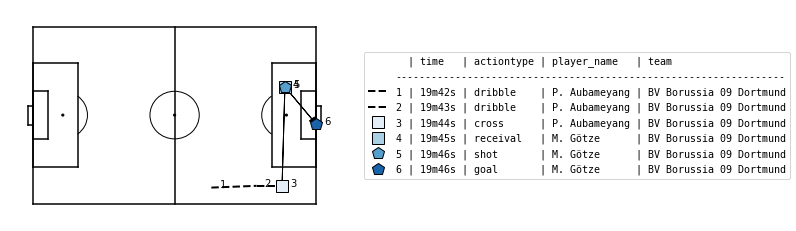

In [13]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][1:2].index):
    a = atomic_actions[shot-5:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

## Compute features and labels

In [14]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [15]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 306


In [16]:
#Example of final framework
print('Features')
display( pd.HDFStore(features_h5)["game_2516847"].head()) #With lags -1,-2.
print('Labels')
display(pd.HDFStore(labels_h5)["game_2516847"].head())

Features


,type_id_a0,type_id_a1,type_id_a2,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,...,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
0,0,0,0,True,False,False,False,False,False,False,...,3.683304,3.683304,1,3.683304,3.683304,1,3.683304,3.683304,0.000000,0.000000
1,23,0,0,False,False,False,False,False,False,False,...,4.954406,4.954406,1,3.683304,3.683304,1,3.683304,3.683304,1.271101,1.271101
2,0,23,0,True,False,False,False,False,False,False,...,6.225507,6.225507,1,4.954406,4.954406,1,3.683304,3.683304,1.271101,2.542203
3,23,0,23,False,False,False,False,False,False,False,...,7.653658,7.653658,1,6.225507,6.225507,1,4.954406,4.954406,1.428151,2.699253
4,0,23,0,True,False,False,False,False,False,False,...,9.081809,9.081809,1,7.653658,7.653658,1,6.225507,6.225507,1.428151,2.856302


Labels


,scores,concedes,goal
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


# Predictions

In [17]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [18]:
# 1. Select feature set X
xfns = [
    fs.actiontype_onehot,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.movement_polar,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 3

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

In [19]:
### load model 
model = pickle.load(open('trained_model.sav', 'rb'))

In [20]:
#Prediction per tutte le partite
gamesX, gamesY = getXY(games,Xcols)
Y_hat = pd.DataFrame()
for col in gamesY.columns:
    Y_hat[col] = [p[1] for p in model[col].predict_proba(gamesX)]

Selecting label: 100%|██████████| 306/306 [00:03<00:00, 85.37it/s] 


In [21]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading actions of each game"):
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 306/306 [00:05<00:00, 52.03it/s]


## VAEP

In [22]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 306


In [23]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"] #Solo azioni
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    ) #Azioni con giocatori/team.
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 306/306 [00:19<00:00, 15.59it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [24]:
#Retrieve roles for each player
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role','currentTeamId']]
Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

In [25]:
A["count"] = 1
# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id","vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
#Add the last team for which the player has played
playersR = playersR.merge(A[["player_id","team_name_short"]].groupby('player_id').tail(1), on = 'player_id')
# Add player name
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR = pd.merge(playersR, df_players, left_on ='player_id', right_on = 'wyId', how = 'left').drop(['wyId','shortName'], axis = 1)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","Role", "team_name_short","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,Role,team_name_short,vaep_value,offensive_value,defensive_value,count
70,14817,R. Lewandowski,Forward,Bayern M\u00fcnchen,29.307600,29.117645,0.189955,1785
137,15265,T. Horn,Goalkeeper,K\u00f6ln,22.436154,1.941795,20.494358,1924
198,19525,A. Schwolow,Goalkeeper,Freiburg,20.465304,2.730129,17.735175,2421
158,15795,K. Casteels,Goalkeeper,Wolfsburg,20.365995,1.714116,18.651879,2400
309,173214,T. Werner,Forward,RB Leipzig,19.839453,19.453190,0.386264,1968
254,65180,M. Gregoritsch,Forward,Augsburg,19.612399,17.937280,1.675118,1990
105,15032,R. Zieler,Goalkeeper,Stuttgart,18.896671,1.940477,16.956194,2369
245,54579,R. Jarstein,Goalkeeper,Hertha BSC,18.658441,1.512660,17.145780,2030
350,253822,J. Pavlenka,Goalkeeper,Werder Bremen,18.599525,1.342112,17.257413,2122
259,69411,A. Kramarić,Forward,Hoffenheim,18.481530,17.587830,0.893700,2318


In [26]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats.rename(columns={'team_name_short':'Team'}, inplace = True)
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played

In [27]:
#filename = 'players_ger.sav'
#pickle.dump(stats, open(filename, 'wb'))
stats = pickle.load(open('players_ger.sav', 'rb'))

In [28]:
stats = stats[stats.minutes_played > 1530] # at least 17 full games played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
69,14817,R. Lewandowski,Forward,Bayern M\u00fcnchen,29.307600,29.117645,0.189955,1785,2247,1.173869,1.166261,0.007608
289,134397,S. Gnabry,Midfielder,Hoffenheim,14.084328,13.713988,0.370340,1488,1561,0.812037,0.790685,0.021352
110,15085,S. Wagner,Forward,Bayern M\u00fcnchen,14.855619,13.732331,1.123288,1262,1667,0.802043,0.741398,0.060645
258,69411,A. Kramarić,Forward,Hoffenheim,18.481530,17.587830,0.893700,2318,2343,0.709918,0.675589,0.034329
139,15292,M. Uth,Forward,Hoffenheim,17.628693,17.151210,0.477483,1597,2278,0.696480,0.677616,0.018865
435,388267,L. Bailey,Forward,Bayer Leverkusen,17.874424,16.601703,1.272721,2706,2320,0.693404,0.644032,0.049373
308,173214,T. Werner,Forward,RB Leipzig,19.839453,19.453190,0.386264,1968,2608,0.684644,0.671314,0.013330
38,14727,A. Robben,Midfielder,Bayern M\u00fcnchen,11.856626,11.432323,0.424303,2120,1559,0.684475,0.659980,0.024495
18,7904,S. Kalou,Forward,Hertha BSC,17.380242,14.628992,2.751250,1784,2287,0.683962,0.575693,0.108270
253,65180,M. Gregoritsch,Forward,Augsburg,19.612399,17.937280,1.675118,1990,2637,0.669365,0.612194,0.057171


In [29]:
stats[stats.Role == "Forward"].sort_values('vaep_rating', ascending = False)[:10].reset_index(drop = True)[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
0,R. Lewandowski,Forward,Bayern M\u00fcnchen,1.173869
1,S. Wagner,Forward,Bayern M\u00fcnchen,0.802043
2,A. Kramarić,Forward,Hoffenheim,0.709918
3,M. Uth,Forward,Hoffenheim,0.696480
4,L. Bailey,Forward,Bayer Leverkusen,0.693404
5,T. Werner,Forward,RB Leipzig,0.684644
6,S. Kalou,Forward,Hertha BSC,0.683962
7,M. Gregoritsch,Forward,Augsburg,0.669365
8,L. Alario,Forward,Bayer Leverkusen,0.649417
9,A. Finnbogason,Forward,Augsburg,0.646246


In [30]:
stats[stats.Role == "Defender"].sort_values('vaep_rating', ascending = False)[:10].reset_index(drop = True)[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
0,D. Alaba,Defender,Bayern M\u00fcnchen,0.591183
1,J. Boateng,Defender,Bayern M\u00fcnchen,0.448494
2,S. Sané,Defender,Hannover 96,0.415340
3,C. Günter,Defender,Freiburg,0.359881
4,J. Kimmich,Defender,Bayern M\u00fcnchen,0.359744
5,D. Heintz,Defender,K\u00f6ln,0.358487
6,B. Hübner,Defender,Hoffenheim,0.351344
7,M. Ginter,Defender,Borussia M'gladbach,0.348083
8,K. Papadopoulos,Defender,Hamburger SV,0.321733
9,Naldo,Defender,Schalke 04,0.315911


# Salary

In [31]:
ger = pd.read_excel('/Users/leonardoyang/Desktop/Tesi/Data/bundesliga/2017-2018/all_bundesliga_2017-2018.xlsx')
ger = ger[ger['Annual Gross(IN EUR)']>0]
ger = ger.drop_duplicates(subset=["Player"], keep='last')
ger.drop('Unnamed: 0', axis = 1, inplace = True)

ger['Name'] = [ger['Player'][i-1:i].values[0].split()[0] for i in range(1,len(ger.Player)+1)]
ger['Surname'] = [ger['Player'][i-1:i].values[0].split()[-1] for i in range(1,len(ger.Player)+1)]

In [32]:
#Retrieve player full name and surname
players['Name'] =[players['player_name'][i-1:i].values[0].split()[0] for i in range(1,len(players.player_name)+1)]
players['Surname'] =[players['player_name'][i-1:i].values[0].split()[-1] for i in range(1,len(players.player_name)+1)]
giocatori = stats.merge(players, on = 'player_id').drop(['nickname'], axis = 1)

#Merge players' stats and salary based on surname,name. Those players not matched due to language barriers were manually added by including their WyID in the salary data.
df = pd.merge(giocatori,ger, on = ['Name','Surname'], how = 'left').sort_values('Annual Gross(IN EUR)', ascending = False).rename(columns={'Annual Gross(IN EUR)':'Salary'})
df = df[['player_id','Player','Age','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Salary']]
missing = pd.merge(df,ger, left_on = 'player_id', right_on = 'ID')
missing = missing[['player_id','Player_y','Age_y','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Annual Gross(IN EUR)']]
missing.rename(columns={'Player_y':'Player','Age_y':'Age','Annual Gross(IN EUR)':'Salary'}, inplace = True)

df = pd.concat([df,missing]).rename(columns = {'Role_x':'Role','Team_x':'Team'}).reset_index(drop=True)
df = df.dropna().drop('player_id', axis = 1).drop_duplicates()
#Create VAEP/Salary
df['vaep/salary'] = df['vaep_value']*10**4/ df['Salary']
display(df[(df['Role']=='Defender')].sort_values('vaep/salary',ascending = False).groupby('Role').mean())
display(df[(df['Role']=='Forward')].sort_values('vaep/salary',ascending = False).groupby('Role').mean())

,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Defender,25.130435,6.152414,3.570782,2.581632,3057.057971,2378.681159,0.230168,2.074290e+06,0.046952


,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Forward,25.857143,12.972054,12.141886,0.830168,1779.107143,2171.214286,0.528646,2.889929e+06,0.08263


In [33]:
df.groupby('Role').agg(['mean']).iloc[:2][['vaep_value','Salary','vaep/salary']].round(4)

,vaep_value,Salary,vaep/salary
,mean,mean,mean
Role,,,
Defender,6.1524,2.074290e+06,0.0470
Forward,12.9721,2.889929e+06,0.0826


# Top11

In [34]:
gk = df[df['Role']=='Goalkeeper'].sort_values('vaep/salary',ascending = False)[:5]
dif = df[df['Role']=='Defender'].sort_values('vaep/salary',ascending = False)[:5]
cen = df[df['Role']=='Midfielder'].sort_values('vaep/salary',ascending = False)[:5]
att = df[df['Role']=='Forward'].sort_values('vaep/salary',ascending = False)[:5]

In [35]:
top_11 = gk.append(dif).append(cen).append(att)
#top_11['Salary'] = top_11['Salary'].astype(int).map('{:,}'.format)
top_11 = top_11[['Player','Age','Role','Team','vaep_rating','minutes_played','vaep_value','Salary','vaep/salary']]
top_11.loc[:,'vaep_rating':] = top_11.loc[:,'vaep_rating':].round(4)
order = ['Goalkeeper','Defender','Midfielder','Forward']
top_11["Role"] = pd.Categorical(top_11["Role"], categories=order, ordered=True)
n = {'Goalkeeper':1, 'Defender':4,'Midfielder':3, 'Forward':3}
top_11 = top_11.groupby('Role').apply(lambda x: x.sort_values("vaep_rating", ascending=False)).drop('Role', axis = 1).reset_index()
top_11 = top_11.groupby('Role').apply(lambda x: x.head(n[x.name])).drop('level_1', axis = 1).reset_index(drop=True)
top_11.index =top_11.index +1
top_11[['Player','Age','Role','Team','vaep_rating','vaep_value','Salary','vaep/salary']]

,Player,Age,Role,Team,vaep_rating,vaep_value,Salary,vaep/salary
1,Alexander Schwolow,25.0,Goalkeeper,Freiburg,0.6041,20.4653,592000.0,0.3457
2,Christian Günter,24.0,Defender,Freiburg,0.3599,12.8477,772000.0,0.1664
3,Benjamin Hübner,27.0,Defender,Hoffenheim,0.3513,9.5058,1030000.0,0.0923
4,Daniel Brosinski,28.0,Defender,Mainz 05,0.2658,7.7589,691000.0,0.1123
5,Thilo Kehrer,20.0,Defender,Schalke 04,0.2064,5.7141,232000.0,0.2463
6,Julian Brandt,21.0,Midfielder,Bayer Leverkusen,0.6208,16.6938,987000.0,0.1691
7,Marius Wolf,22.0,Midfielder,Eintracht Frankfurt,0.3786,10.3990,641000.0,0.1622
8,Valentino Lazaro,21.0,Midfielder,Hertha BSC,0.2688,5.8411,396000.0,0.1475
9,Mark Uth,25.0,Forward,Hoffenheim,0.6965,17.6287,772000.0,0.2284
10,Michael Gregoritsch,23.0,Forward,Augsburg,0.6694,19.6124,987000.0,0.1987


In [36]:
print("Average salary per Team(~starting 11)): ",('{:,}'.format(int(df.groupby('Team').sum()['Salary'].mean()))),"€")
print("Median salary per Team(~starting 11)): ",('{:,}'.format(int(df.groupby('Team').sum()['Salary'].median()))),"€")
print("Salary per Top_11: " + ('{:,}'.format(int(top_11.Salary.sum()))+ "€"))

Average salary per Team(~starting 11)):  20,069,777 €
Median salary per Team(~starting 11)):  14,723,500 €
Salary per Top_11: 7,872,000€


In [37]:
#For latex
d = df[df['Role']=='Defender'].sort_values('vaep_rating',ascending = False)[['Player','Age','Role','Team','vaep_rating','vaep_value','Salary','vaep/salary']][:5].reset_index(drop = True)
a = df[df['Role']=='Forward'].sort_values('vaep_rating',ascending = False)[['Player','Age','Role','Team','vaep_rating','vaep_value','Salary','vaep/salary']][:5].reset_index(drop = True)
sal = pd.concat([d,a])
sal['Salary'] = sal['Salary'].astype(int).map('{:,}'.format)
sal.loc[:,'vaep_rating':] = sal.loc[:,'vaep_rating':].round(4)
sal

,Player,Age,Role,Team,vaep_rating,vaep_value,Salary,vaep/salary
0,David Alaba,25.0,Defender,Bayern M\u00fcnchen,0.5912,10.5690,"9,871,000",0.0107
1,Jérôme Boateng,28.0,Defender,Bayern M\u00fcnchen,0.4485,8.3868,"11,846,000",0.0071
2,Salif Sané,26.0,Defender,Hannover 96,0.4153,13.9508,"2,468,000",0.0565
3,Christian Günter,24.0,Defender,Freiburg,0.3599,12.8477,"772,000",0.1664
4,Joshua Kimmich,22.0,Defender,Bayern M\u00fcnchen,0.3597,9.5932,"1,485,000",0.0646
0,Robert Lewandowski,28.0,Forward,Bayern M\u00fcnchen,1.1739,29.3076,"15,795,000",0.0186
1,Sandro Wagner,29.0,Forward,Bayern M\u00fcnchen,0.8020,14.8556,"2,972,000",0.0500
2,Mark Uth,25.0,Forward,Hoffenheim,0.6965,17.6287,"772,000",0.2284
3,Timo Werner,21.0,Forward,RB Leipzig,0.6846,19.8395,"1,981,000",0.1001
4,Salomon Kalou,31.0,Forward,Hertha BSC,0.6840,17.3802,"2,476,000",0.0702
